In [1]:
from __future__ import annotations

from typing import  List
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: C:\Users\markm\Documents\programming\Flexible-Cloud-Resource\analysis


In [2]:
from extra.visualise import plot_allocation_results, ImageFormat
from core.fixed_task import FixedTask, FixedSumSpeeds
from core.core import reset_model
from core.task import Task
from core.server import Server
from greedy.greedy import greedy_algorithm
from greedy.resource_allocation_policy import SumPercentage
from greedy.server_selection_policy import SumResources
from greedy.value_density import ResourceSum
from optimal.fixed_optimal import fixed_optimal
from optimal.flexible_optimal import flexible_optimal

In [3]:
tasks = [
    Task("Task 1",  required_storage=100, required_computation=100, required_results_data=50, deadline=10, value=100),
    Task("Task 2",  required_storage=75,  required_computation=125, required_results_data=40, deadline=10, value=90),
    Task("Task 3",  required_storage=125, required_computation=110, required_results_data=45, deadline=10, value=110),
    Task("Task 4",  required_storage=100, required_computation=75,  required_results_data=60, deadline=10, value=75),
    Task("Task 5",  required_storage=85,  required_computation=90,  required_results_data=55, deadline=10, value=125),
    Task("Task 6",  required_storage=75,  required_computation=120, required_results_data=40, deadline=10, value=100),
    Task("Task 7",  required_storage=125, required_computation=100, required_results_data=50, deadline=10, value=80),
    Task("Task 8",  required_storage=115, required_computation=75,  required_results_data=55, deadline=10, value=110),
    Task("Task 9",  required_storage=100, required_computation=110, required_results_data=60, deadline=10, value=120),
    Task("Task 10", required_storage=90,  required_computation=120, required_results_data=40, deadline=10, value=90),
    Task("Task 11", required_storage=110, required_computation=90,  required_results_data=45, deadline=10, value=100),
    Task("Task 12", required_storage=100, required_computation=80,  required_results_data=55, deadline=10, value=100)
]

servers = [
    Server("Server 1", storage_capacity=400, computation_capacity=100, bandwidth_capacity=220),
    Server("Server 2", storage_capacity=450, computation_capacity=100, bandwidth_capacity=210),
    Server("Server 3", storage_capacity=385, computation_capacity=90, bandwidth_capacity=250)
]

In [4]:
def print_tasks(tasks: List[Task]):
    max_task_name_len = max(len(task.name) for task in tasks) + 1
    print("{:<{}}| Value |{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}| {}"
          .format("Name", max_task_name_len, "Storage", "Computation", "Results", "Deadline", 
                  "Loading", "Compute", "Sending", "Server"))
    
    for task in tasks:
        print("{:<{name_len}}|{:^7.1f}|{:^9}|{:^13}|{:^9}|{:^10}|{:^9}|{:^9}|{:^9}|{:^10}"
              .format(task.name, task.value, task.required_storage, task.required_computation, task.required_results_data,
                      task.deadline, task.loading_speed, task.compute_speed, task.sending_speed,
                      task.running_server.name if task.running_server else "None", name_len=max_task_name_len))

### Optimal Solution

Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   30    |   20    |   30    | Server 3 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   61    |   17    |   29    | Server 3 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   31    |   25    |   29    | Server 2 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   28    |   24    |   19    | Server 2 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   20    |   23    |   30    | Server 2 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   37    |   20    |   21    | Server 1 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   36    |   28    |   17    | Server 2 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   30    |   31    |   15    | Server 1 
Task 9  | 120.0 |   100   |     110     |   60    |    10    |   34    |   2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figures/allocation/pdf/optimal_flexible_resource_allocation.pdf


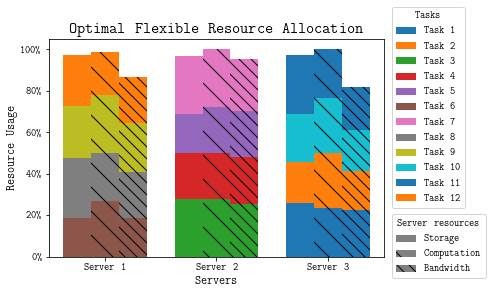

In [5]:
optimal_results = flexible_optimal(tasks, servers, time_limit=5)

print_tasks(tasks)
plot_allocation_results(tasks, servers, "Optimal Flexible Resource Allocation",
                        save_formats=(ImageFormat.PNG, ImageFormat.EPS, ImageFormat.PDF), 
                        minimum_allocation=True)
reset_model(tasks, servers)

### Fixed Solution

Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   24    |   30    |   20    | Server 1 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   23    |   27    |   19    | Server 2 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   35    |   28    |   18    | Server 3 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   25    |   25    |   20    |   None   
Task 5  | 125.0 |   85    |     90      |   55    |    10    |   21    |   27    |   21    | Server 3 
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   20    |   29    |   19    | Server 1 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   33    |   28    |   19    |   None   
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   30    |   22    |   20    | Server 2 
Task 9  | 120.0 |   100   |     110     |   60    |    10    |   30    |   2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figures/allocation/pdf/optimal_fixed_resource_allocation.pdf


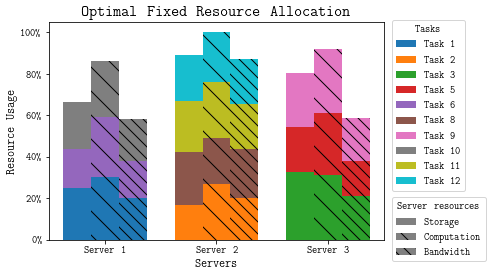

In [5]:
fixed_tasks = [FixedTask(task, FixedSumSpeeds(), fixed_name=False) for task in tasks]
fixed_results = fixed_optimal(fixed_tasks, servers, time_limit=5)

print_tasks(fixed_tasks)
plot_allocation_results(fixed_tasks, servers, "Optimal Fixed Resource Allocation",
                        save_formats=(ImageFormat.PNG, ImageFormat.EPS, ImageFormat.PDF))
reset_model(tasks, servers)

### Greedy Solution

Name    | Value | Storage | Computation | Results | Deadline | Loading | Compute | Sending | Server
Task 1  | 100.0 |   100   |     100     |   50    |    10    |   35    |   21    |   21    | Server 3 
Task 2  | 90.0  |   75    |     125     |   40    |    10    |   30    |   22    |   22    | Server 3 
Task 3  | 110.0 |   125   |     110     |   45    |    10    |   40    |   22    |   24    | Server 1 
Task 4  | 75.0  |   100   |     75      |   60    |    10    |   30    |   18    |   24    | Server 2 
Task 5  | 125.0 |   85    |     90      |   55    |    10    |    0    |    0    |    0    |   None   
Task 6  | 100.0 |   75    |     120     |   40    |    10    |   25    |   24    |   20    | Server 2 
Task 7  | 80.0  |   125   |     100     |   50    |    10    |   36    |   23    |   23    | Server 1 
Task 8  | 110.0 |   115   |     75      |   55    |    10    |   34    |   17    |   25    | Server 3 
Task 9  | 120.0 |   100   |     110     |   60    |    10    |   31    |   2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Save file location: figures/allocation/pdf/greedy_flexible_resource_allocation.pdf


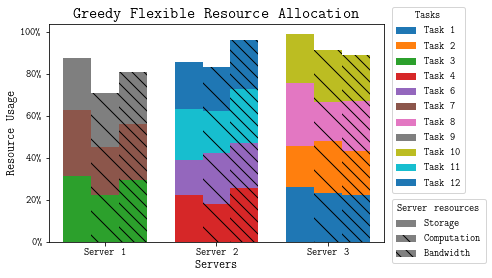

In [7]:
greedy_results = greedy_algorithm(tasks, servers, ResourceSum(), SumResources(), SumPercentage())

print_tasks(tasks)
plot_allocation_results(tasks, servers, "Greedy Flexible Resource Allocation", 
                       save_formats=(ImageFormat.PNG, ImageFormat.EPS, ImageFormat.PDF))

### Optimal, Fixed and Greedy results

In [12]:
results = {'Optimal': optimal_results, 'Fixed': fixed_results, 'Greedy': greedy_results}
max_name_len = max(len(name) for name in results.keys())
max_storage_len = max(len(str(list(result.data['server storage used'].values()))) 
                      for result in results.values())
max_computation_len = max(len(str(list(result.data['server computation used'].values()))) 
                          for result in results.values())
max_bandwidth_len = max(len(str(list(result.data['server bandwidth used'].values()))) 
                        for result in results.values())

print("{:<{}} | Value | {:^{}} | {:^{}} | {:^{}} | Num Jobs"
      .format("Name", max_name_len, "Storage", max_storage_len, 
              "Computation", max_computation_len, "Bandwidth", max_bandwidth_len))
for name, result in results.items():
    print("{:<{}} | {:^5} | {:^{}} | {:^{}} | {:^{}} | {}".format(
        name, max_name_len, result.social_welfare, 
        str(list(result.data['server storage used'].values())), max_storage_len, 
        str(list(result.data['server computation used'].values())), max_computation_len,
        str(list(result.data['server bandwidth used'].values())), max_bandwidth_len,
        str(list(result.data['server num tasks allocated'].values()))))

Name    | Value |        Storage        |     Computation     |       Bandwidth       | Num Jobs
Optimal | 1200  | [0.975, 0.967, 0.974] |  [1.0, 1.0, 0.967]  |    [1.0, 1.0, 1.0]    | [4, 4, 4]
Fixed   | 1045  | [0.662, 0.889, 0.805] | [0.86, 1.0, 0.922]  | [0.582, 0.871, 0.588] | [3, 4, 3]
Greedy  | 1075  | [0.875, 0.856, 0.987] | [0.71, 0.83, 0.911] | [0.809, 0.962, 0.888] | [3, 4, 4]
